https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab
Conv2D(output_depth,(filter_window_height, filter_window_width))

In [ ]:
from google.colab import files


In [ ]:
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tongpython/cat-and-dog

!mkdir cats_vs_dogs_data
!mv cat-and-dog.zip /content/cats_vs_dogs_data/
%cd /content/cats_vs_dogs_data/
!unzip cat-and-dog.zip
!unzip test_set.zip
!unzip training_set.zip


# finding the number of smples in training and test data

In [ ]:
% cd /content/cats_vs_dogs_data/training_set/cats/

/content/cats_vs_dogs_data/training_set/cats


In [ ]:
train_cats_number = !find . -type f | wc -l


In [ ]:
% cd /content/cats_vs_dogs_data/training_set/dogs/

/content/cats_vs_dogs_data/training_set/dogs


In [ ]:
train_dogs_number = !find . -type f | wc -l


In [ ]:
% cd /content/cats_vs_dogs_data/test_set/dogs/

/content/cats_vs_dogs_data/test_set/dogs


In [ ]:
test_dogs_number = !find . -type f | wc -l


In [ ]:
% cd /content/cats_vs_dogs_data/test_set/cats/

/content/cats_vs_dogs_data/test_set/cats


In [ ]:
test_cats_number = !find . -type f | wc -l


In [ ]:
print("# train cats set size",train_cats_number)
print("# train dogs set size",train_dogs_number)
print("# test dogs set size",test_dogs_number)
print("# test cats set size",test_cats_number)

# train cats set size ['4001']
# train dogs set size ['4006']
# test dogs set size ['1013']
# test cats set size ['1012']


# Copying Images to training, validation and test directories

In [ ]:
import os, shutil

In [ ]:
pwd

'/content/cats_vs_dogs_data/test_set/cats'

In [ ]:
cd ..

/content/cats_vs_dogs_data/test_set


In [ ]:
cd ..

/content/cats_vs_dogs_data


In [ ]:
!mkdir validation_set


In [ ]:
cd validation_set/

/content/cats_vs_dogs_data/validation_set


In [ ]:
!mkdir cats
!mkdir dogs

In [ ]:

training_cats_dir = "/content/cats_vs_dogs_data/training_set/cats"
validation_cats_dir = "/content/cats_vs_dogs_data/validation_set/cats"
fnames = ['cat.{}.jpg'.format(i) for i in range(1000,2000)]
for fname in fnames:
  src = os.path.join(training_cats_dir, fname)
  dst = os.path.join(validation_cats_dir, fname)
  shutil.move(src,dst)

In [ ]:

training_dogs_dir = "/content/cats_vs_dogs_data/training_set/dogs"
validation_dogs_dir = "/content/cats_vs_dogs_data/validation_set/dogs"
fnames = ['dog.{}.jpg'.format(i) for i in range(1000,2000)]
for fname in fnames:
  src = os.path.join(training_dogs_dir, fname)
  dst = os.path.join(validation_dogs_dir, fname)
  shutil.move(src,dst)

In [ ]:
test_cats_dir = "/content/cats_vs_dogs_data/test_set/cats"
test_dogs_dir = "/content/cats_vs_dogs_data/test_set/dogs"

# So, now we have 3 directories for training test and validation:
content/cats_vs_dogs_data

In [ ]:
print("total training cat images:", len(os.listdir(training_cats_dir)))
print("total training dog images:", len(os.listdir(training_dogs_dir)))
print("total test cat images:", len(os.listdir(test_cats_dir)))
print("total test dog images:", len(os.listdir(test_dogs_dir)))
print("total validation cat images:", len(os.listdir(validation_cats_dir)))
print("total validation dog images:", len(os.listdir(validation_dogs_dir)))



total training cat images: 3001
total training dog images: 3006
total test cat images: 1012
total test dog images: 1013
total validation cat images: 1000
total validation dog images: 1000


# Building the model:


In [ ]:
from keras import models
from keras import layers

Using TensorFlow backend.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation="relu",
                       input_shape=(150,150,3)))  # you'll see later that we will resize all image to 150x150
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

# Compilation:
using "RMSprop" as the optimizer/minimizer of the error function.
Since you are using sigmoid as the activation in the final layer we'll use binary crossentropy as the loss metric

In [ ]:
from keras import optimizers

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['acc'])

# Data Preprocessing:
As we know that data should be transformed into an appropriately preprocessed floating point tensors before being fed to the network.
Our data currently is in the form of jpg images so we need to transform it to the desired input form.


1.   Read the picture files
2.   Decode the picture content to RGB grid of pixels
3.   convert these to folating point tensors.
4    Rescale values between [0,1] as the neural nets find it easier to deal with small numbers.

So, Since Keras is a great library it does provide us with image pre-processing helper tools located at keras.preprocessing.image named a class called "ImageDataGenerator".
It can automatically convert the images on disk into batches of preprocessed tensors.




In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) #rescale all images [0,1]
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                "/content/cats_vs_dogs_data/training_set",
                  target_size=(150,150),
                  batch_size=20,
                  class_mode="binary")
validation_generator = validation_datagen.flow_from_directory(
                "/content/cats_vs_dogs_data/validation_set",
                  target_size=(150,150),
                  batch_size=20,
                  class_mode="binary")


Found 6005 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:",labels_batch.shape)
  break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


# Fitting the model to the data using generator

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=250,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=100)

In [ ]:
model.save('cats_dogs_1.h5')

# Displaying curves for loss and accuracy during training

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history["val_acc"]
loss = history.history['loss']
val_loss = history.history["val_loss"]

In [ ]:
epochs = range(1,len(acc)+1)

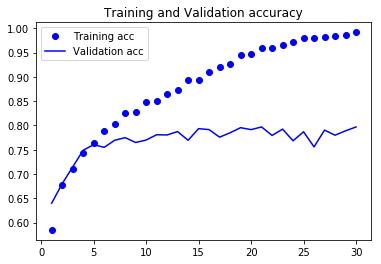

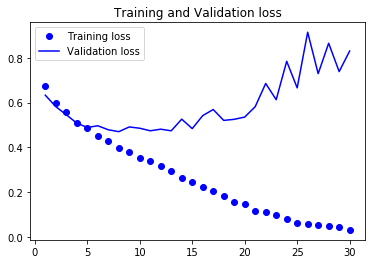

In [ ]:
plt.plot(epochs, acc,"bo",label="Training acc")
plt.plot(epochs, val_acc,"b",label="Validation acc")
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss,"bo",label="Training loss")
plt.plot(epochs, val_loss,"b",label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

# Overfitting:
As you can see that the training accuracy goes on increasing while the validation accuracy stalls aroud 75%, which is just ok. but if you look at the loss plot, you see that the training loss goes on decreasing but the validation loss hits its minimum aat around 14 epochs but after that loss goes on increasing which indicates overfitting of the model
## in order to avoid this we will use Data Augmentation. We can also use dropout and L2 regularization but for now we'll focus on data augmentation to tackle over fitting, which is more  suitable for overfitting related to visual recognition

# Data Augmentation:
It is the process of generating more training data from existing training samples. this process uses a number of transformations on the existing images to yield new samples for training.  The goal of augmentation is first increase the number of samples scuh that the model doesn't see the image twice while training.
In Keras augmentation is done by using a combination of transforamtion( to be applied on the images) via the ImageDataGenerator instance.

## avoiding overfiitting but really?
So, eventhough your model would never see the same mage twie but your augmented images are just slight transmations from the real image so, they still have high corellation which might be a factor for overfitting , that;s one of the reason we use Dropout to avoid this.

In [ ]:
datagen = ImageDataGenerator(
            rotation_range =40,# is a value in degree between[0-180] to randomly rotate pictures
            width_shift_range = 0.2, #horizontally translate picture in space
            height_shift_range = 0.2, #vertically translate picture in space
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode="nearest"
            )

# Visualizing the augmented Images

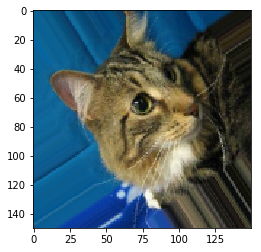

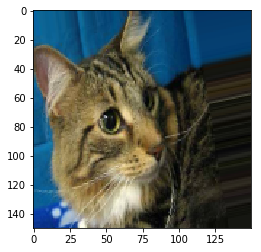

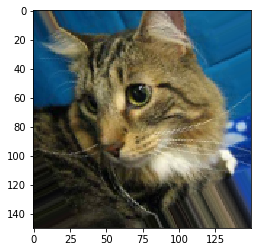

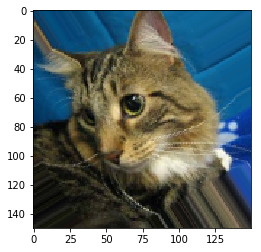

In [ ]:
from keras.preprocessing import image

fnames = [os.path.join(training_cats_dir, fname) for
        fname in os.listdir(training_cats_dir)]
img_path = fnames[9]
img = image.load_img(img_path, target_size=(150,150))
x= image.img_to_array(img)
x = x.reshape((1,) +x.shape)

i=0
for batch in datagen.flow(x,batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%4 ==0:
    break
    
plt.show()



## Augmentation is not going to entirely solve the overfitting problem so, we have to use dropout in the new model. 
### so, let's make a new model adding dropout as well.

In [ ]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3,3), activation="relu",
                       input_shape=(150,150,3)))  # you'll see later that we will resize all image to 150x150
model1.add(layers.MaxPooling2D((2,2)))

model1.add(layers.Conv2D(64,(3,3),activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))

model1.add(layers.Conv2D(128,(3,3),activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))

model1.add(layers.Conv2D(128, (3,3), activation='relu'))
model1.add(layers.MaxPooling2D((2,2)))

model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(512,activation="relu"))
model1.add(layers.Dense(1,activation="sigmoid"))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=["acc"])

# Training Convnets using data augmentation generators

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255) # we shouldn't augment the validation data


train_generator = train_datagen.flow_from_directory(
                "/content/cats_vs_dogs_data/training_set",
                  target_size=(150,150),
                  batch_size=20,
                  class_mode="binary")
validation_generator = validation_datagen.flow_from_directory(
                "/content/cats_vs_dogs_data/validation_set",
                  target_size=(150,150),
                  batch_size=20,
                  class_mode="binary")
history = model1.fit_generator(
      train_generator,
      steps_per_epoch=250,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=100)

In [ ]:
model1.save('cats_dogs_2.h5')

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history["val_acc"]
loss = history.history['loss']
val_loss = history.history["val_loss"]

In [ ]:
epochs = range(1,len(acc)+1)

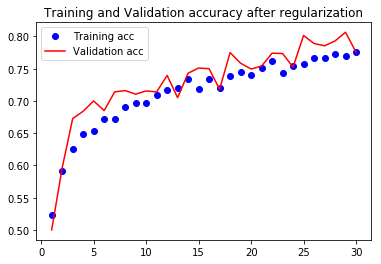

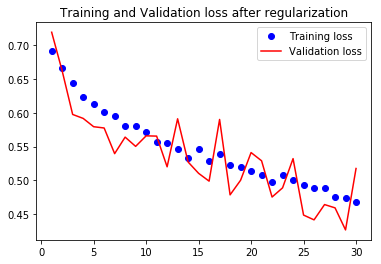

In [ ]:
plt.plot(epochs, acc,"bo",label="Training acc")
plt.plot(epochs, val_acc,"r",label="Validation acc")
plt.title("Training and Validation accuracy after regularization")
plt.legend()

plt.figure()

plt.plot(epochs, loss,"bo",label="Training loss")
plt.plot(epochs, val_loss,"r",label="Validation loss")
plt.title("Training and Validation loss after regularization")
plt.legend()

plt.show()

So, As you can see from above that we have sigificationlt reduced overfitting

# Visualization of what convnets learn

## Visualizing Intermediate activations


1.   for understanding how different convnet layers transform their input
2.   meaning of individual convnet filters

So, what we are trying to do here is that we want to see how the input is decomposed into different filters learned by the network.



In [ ]:
from keras.models import load_model

In [ ]:
model2 = load_model('cats_dogs_2.h5')

In [ ]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

let's try to see just one image as input!

---



In [ ]:
!pwd

/content/cats_vs_dogs_data/validation_set


In [ ]:
img_path = "/content/cats_vs_dogs_data/test_set/cats/cat.4201.jpg"

from keras.preprocessing import image
import numpy as np

In [ ]:
img = image.load_img(img_path,target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [ ]:
print(img_tensor.shape)

(1, 150, 150, 3)


# Displayig the test picture

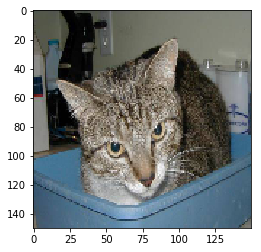

In [ ]:
plt.imshow(img_tensor[0])
plt.show()

# Instantiating a model

In [ ]:
from keras import models

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]

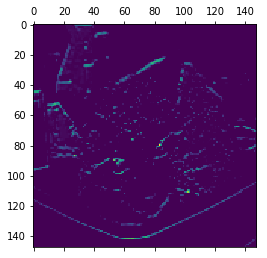

In [ ]:
plt.matshow(first_layer_activation[0,:,:,7], cmap='viridis') #lookig at channel 0 out of 31

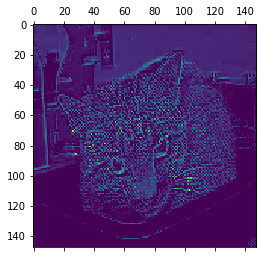

In [ ]:
plt.matshow(first_layer_activation[0,:,:,17], cmap='viridis')

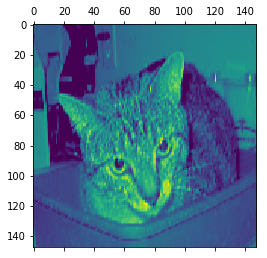

In [ ]:
plt.matshow(first_layer_activation[0,:,:,23], cmap='viridis')

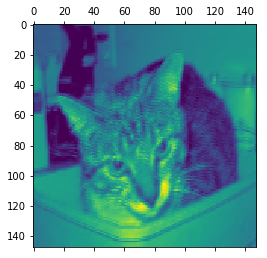

In [ ]:
plt.matshow(first_layer_activation[0,:,:,13], cmap='viridis')

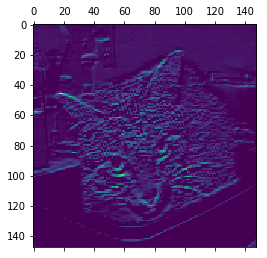

In [ ]:
plt.matshow(first_layer_activation[0,:,:,0], cmap='viridis')

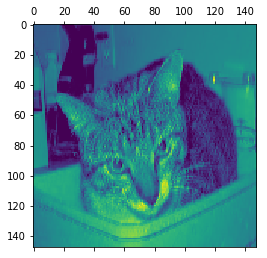

In [ ]:
plt.matshow(first_layer_activation[0,:,:,10], cmap='viridis')

# Visualizing every channel in every intermediate section

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


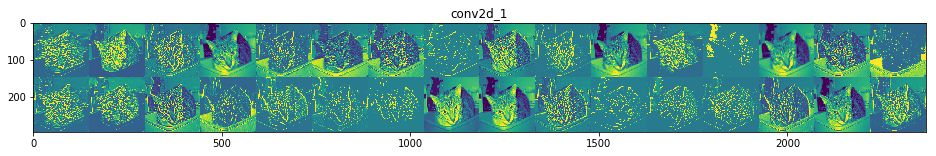

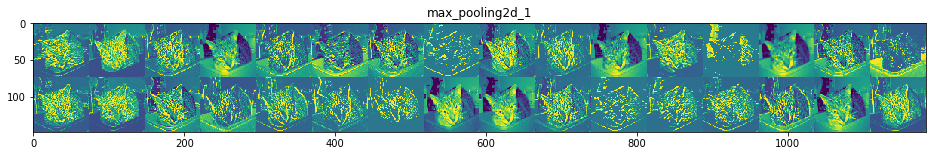

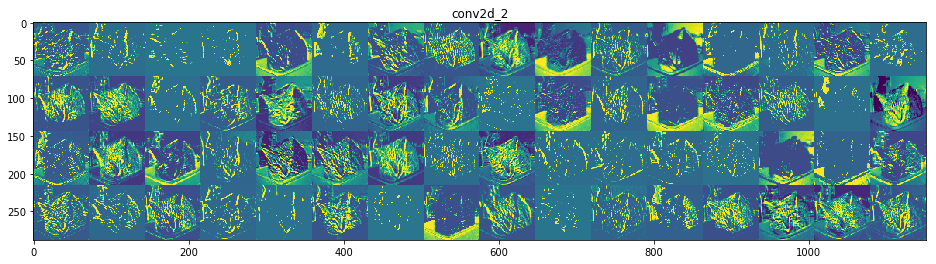

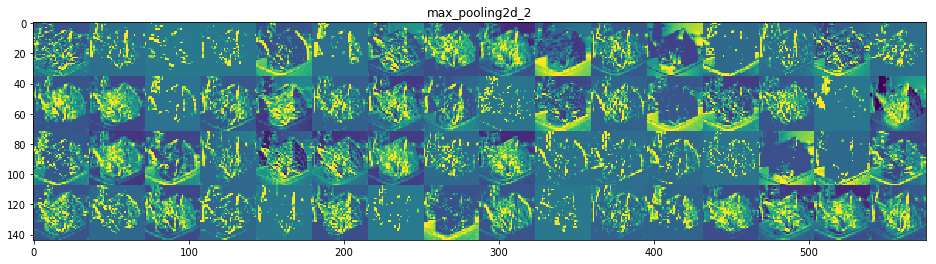

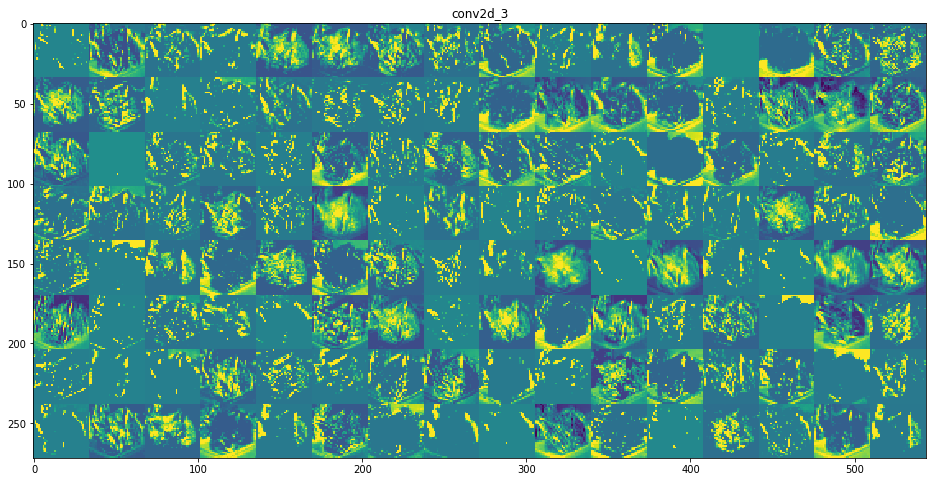

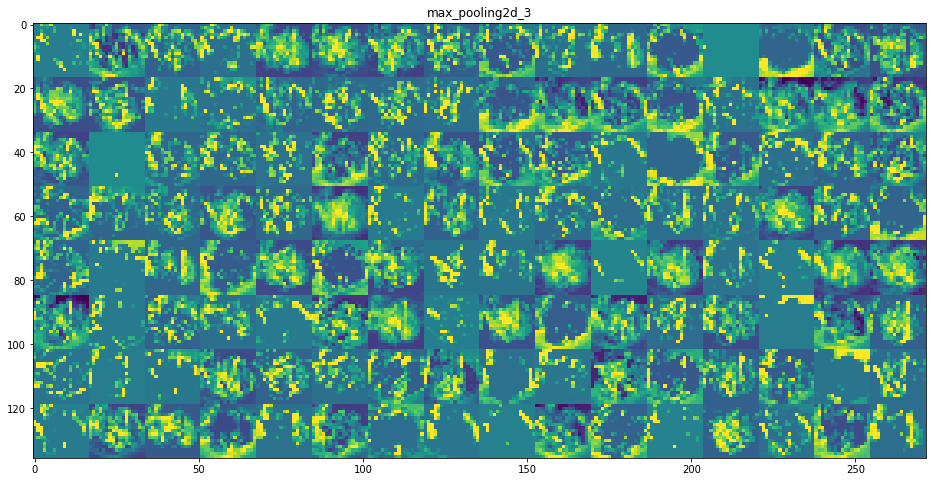

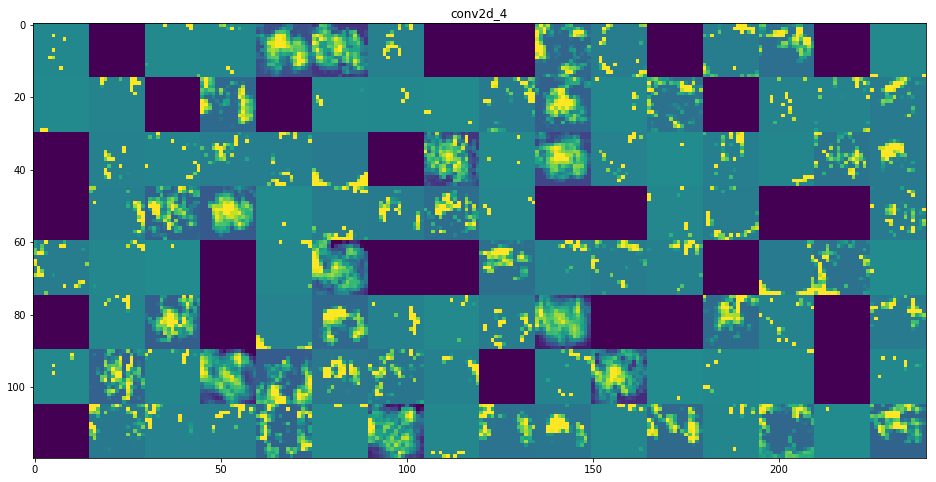

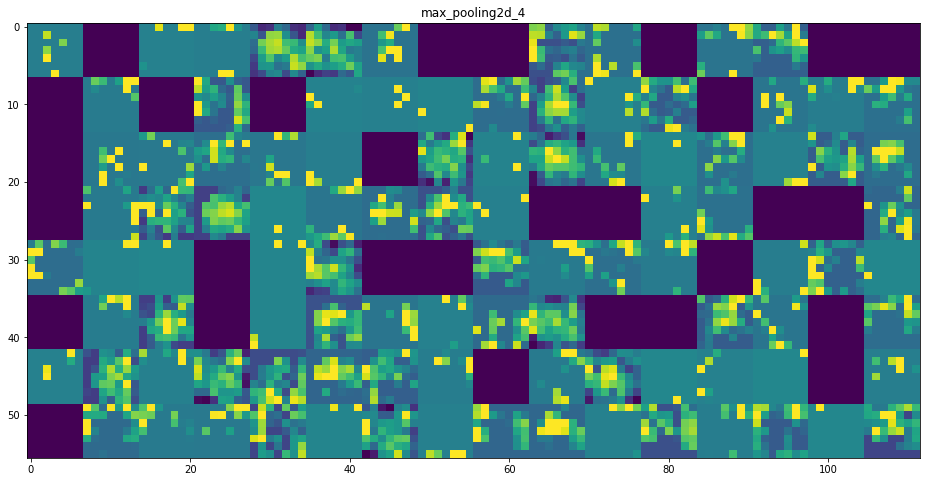

In [ ]:


import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

